<center>
    <h1 id='content-based-filtering' style='color:#7159c1; font-size:350%'>Content-Based Filtering</h1>
    <i style='font-size:125%'>Recommendations of Similar Items by Metadatas</i>
</center>

> **Topics**

```
- ✨ Create Sequential Texts
- ✨ Word Cloud
- ✨ Lower Case
- ✨ Remove Break Lines and Special Characters
- ✨ Calculate TF-IDF
- ✨ Calculate Cosine Similarity
- ✨ Deal with Duplicated Titles
- ✨ Create Search Function
- ✨ Recommendations
```

In [1]:
# ---- Imports ----
import matplotlib.pyplot as plt             # pip install matplotlib
import mplcyberpunk                         # pip install mplcyberpunk
import numpy as np                          # pip install numpy
import pandas as pd                         # pip install pandas
import seaborn as sns                       # pip install seaborn
from sklearn.feature_extraction.text import TfidfVectorizer  # pip install sklearn
from sklearn.metrics.pairwise import linear_kernel           # pip install sklearn
import string                               # pip install string
from wordcloud import WordCloud             # pip install wordcloud

# ---- Constants ----
DATASETS_PATH = ('./datasets')
SEED = (20231227)

# ---- Settings ----
np.random.seed(SEED)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
sns.set_style('darkgrid')
plt.style.use('cyberpunk')

# ---- Functions ----
def generate_metadatas_sequential_text(dataset, features):
    """
    \ Description:
        - iters each dataset row and features parameter's elements;
        - if the value at row[feature] position is different than a single hyphen:
             - the value gets all spaces replaced by underscores;
             - the value gets all commas-spaces replaced by space;
             - sequential_text is incremented by the resultant value and by a space at the end;
             - sequential_text is stripped and appended into sequential_text_list;
             - at the end, sequential_text_list is returned.
    
    \ Paramters:
        - dataset: Pandas DataFrame;
        - features: list of strings.
    """
    sequential_text_list = []
    
    for index, row in dataset.iterrows():
        current_sequential_text = ''
        for feature in features:
            if row[feature] != '-':
                current_sequential_text += row[feature].replace(' ', '_').replace(',_', ' ')
                current_sequential_text += ' '
                     
        sequential_text_list.append(current_sequential_text.strip())
    
    return sequential_text_list

def transform_duplicated_titles(duplicated_titles_list):
    """
    \ Description:
        - passes through each element from the parameter;
        
        - if title is into 'title_count' element:
            - 'title_count' is increased by 1 for the current title;
            - current title is updated by adding a number to the end;
            - the number addition starts from 2, that is, from the first repetition of the current title.
            
        - if title is not into 'title_count':
            - title is inserted into 'title_count' with count equals to 1;
            - the current title is returned as is;
    
    \ Parameters:
        - duplicated_titles_list: list of strings.
    """
    title_count = {}
    result = []

    for title in duplicated_titles_list:
        if title in title_count:
            title_count[title] += 1
            result.append(f'{title} {title_count[title]}')
        else:
            title_count[title] = 1
            result.append(title)
    return result

def get_recommendations(dataset, title, animes_indices, cosine_similarity, number_recommendations=10):
    """
    \ Description:
        - gets the index of the anime that matches the title;
        - gets the pairwise similarity scores of all animes with the chosen anime;
        - sort the animes based on the similarity socres on descending order;
        - gets the scores of the top 'number_recommendations' animes, excluding the chosen one;
        - gets the animes indices;
        - returns the recommended animes id, title, score, genre, is hentai flag and image url.
    
    \ Parameters:
        - dataset: Pandas DataFrame;
        - title: string;
        - animes_indices: list of integers;
        - cosine_similarity: NumPy array of floats;
        - number_recommendation: integer.
    """
    index = animes_indices[title]
    
    similarity_scores = list(enumerate(cosine_similarity[index]))
    similarity_scores = sorted(similarity_scores, key=lambda score: score[1], reverse=True)
    similarity_scores = similarity_scores[1:number_recommendations+1]
    
    recommended_animes_indices = [index[0] for index in similarity_scores]
    recommended_animes_scores = [index[1] for index in similarity_scores]
    
    recommendations_df = dataset.iloc[recommended_animes_indices][
        ['id', 'title', 'score', 'genres', 'is_hentai', 'image_url']
    ].set_index('id')
    recommendations_df['cosine_similarity'] = recommended_animes_scores
    
    return recommendations_df

<h1 id='0-creating-sequential-texts' style='color:#7159c1; border-bottom:3px solid #7159c1; letter-spacing:2px; font-family:JetBrains Mono; font-weight: bold; text-align:left; font-size:240%;padding:0'>✨ | Creating Sequential Texts</h1>

In [2]:
# ---- Reading Dataset ----
animes_df = pd.read_csv(f'{DATASETS_PATH}/anime-transformed-dataset-2023.csv', index_col='id')[
    ['title', 'score', 'genres', 'is_hentai', 'type', 'source', 'image_url']
]

# ---- Generating Sequential Text for Metadatas ----
metadata_features = ['genres', 'type', 'source']
animes_df['metadatas'] = generate_metadatas_sequential_text(animes_df, metadata_features)
animes_df.head()

,title,score,genres,is_hentai,type,source,image_url,metadatas
id,,,,,,,,
1,cowboy bebop,8.75,"award winning, action, sci-fi",0,tv,original,https://cdn.myanimelist.net/images/anime/4/19644.jpg,award_winning action sci-fi tv original
5,cowboy bebop tengoku no tobira,8.38,"action, sci-fi",0,movie,original,https://cdn.myanimelist.net/images/anime/1439/93480.jpg,action sci-fi movie original
6,trigun,8.22,"adventure, action, sci-fi",0,tv,manga,https://cdn.myanimelist.net/images/anime/7/20310.jpg,adventure action sci-fi tv manga
7,witch hunter robin,7.25,"mystery, supernatural, action, drama",0,tv,original,https://cdn.myanimelist.net/images/anime/10/19969.jpg,mystery supernatural action drama tv original
8,bouken ou beet,6.94,"adventure, supernatural, fantasy",0,tv,manga,https://cdn.myanimelist.net/images/anime/7/21569.jpg,adventure supernatural fantasy tv manga


<h1 id='1-word-cloud' style='color:#7159c1; border-bottom:3px solid #7159c1; letter-spacing:2px; font-family:JetBrains Mono; font-weight: bold; text-align:left; font-size:240%;padding:0'>✨ | Word Cloud</h1>

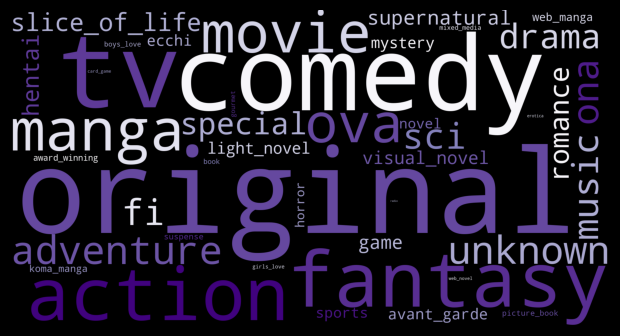

In [3]:
# ---- Plotting Word Cloud ----
metadatas_text = ' '.join(animes_df.metadatas)

metadatas_word_cloud = WordCloud(
    collocations=False # only consider words as unigrams, example, 'Dragon Ball' is considered as two words: 'Dragon' and 'Ball'
     , background_color='black'
    , colormap='Purples'
    , width=2048
    , height=1080
    , random_state=SEED
).generate(metadatas_text)

plt.figure(facecolor='k')
plt.imshow(metadatas_word_cloud)
plt.tight_layout(pad=0)
plt.axis('off')
plt.show()

<h1 id='2-lower-casing-and-removing-all-break-lines-and-special-characters' style='color:#7159c1; border-bottom:3px solid #7159c1; letter-spacing:2px; font-family:JetBrains Mono; font-weight: bold; text-align:left; font-size:240%;padding:0'>✨ | Lower Casing and Removing All Break Lines and Special Characters</h1>

In [4]:
# ---- Lower Casing ----
animes_df.metadatas = animes_df.metadatas.apply(lambda metadata: metadata.lower())

# ---- Removing All Break Lines (\n) and Special Characters (\t \r \x0b \x0c) ----
animes_df.metadatas = animes_df.metadatas.apply(lambda metadata: ' '.join(metadata.split()))

<h1 id='3-calculating-term-frequence-inversee-document-frequence-tfidf' style='color:#7159c1; border-bottom:3px solid #7159c1; letter-spacing:2px; font-family:JetBrains Mono; font-weight: bold; text-align:left; font-size:240%;padding:0'>✨ | Calculating Term Frequence - Inverse Document Frequence (TF-IDF)</h1>

In [5]:
# ---- Calculating TF-IDF ----
tfidf_vectorizer = TfidfVectorizer(analyzer='word', norm='l2', stop_words='english')
tfidf_metadatas = tfidf_vectorizer.fit_transform(animes_df.metadatas)

print(f'- Number of Animes: {tfidf_metadatas.shape[0]}')
print(f'- Number of Words to Describe the Animes: {tfidf_metadatas.shape[1]}')

- Number of Animes: 23748
- Number of Words to Describe the Animes: 43


<h1 id='4-calculating-cosine-similarity' style='color:#7159c1; border-bottom:3px solid #7159c1; letter-spacing:2px; font-family:JetBrains Mono; font-weight: bold; text-align:left; font-size:240%;padding:0'>✨ | Calculating Cosine Similarity</h1>

In [6]:
# ---- Calculating Cosine Similarity ----
cosine_similarity_metadatas = linear_kernel(tfidf_metadatas, tfidf_metadatas)

<h1 id='5-dealing-with-duplicated-titles' style='color:#7159c1; border-bottom:3px solid #7159c1; letter-spacing:2px; font-family:JetBrains Mono; font-weight: bold; text-align:left; font-size:240%;padding:0'>✨ | Dealing with Duplicated Titles</h1>

In [7]:
# ---- Dealing with Duplicated Titles: Getting Duplicated Titles List ----
duplicated_title_indexes = animes_df.title.duplicated(keep=False)
duplicated_title_list = transform_duplicated_titles(
    animes_df[duplicated_title_indexes].sort_values(by='title', ascending=True).title.to_list()
)

In [8]:
# ---- Dealing with Duplicated Titles: Transformin the Titles ----
duplicated_animes_df = animes_df[duplicated_title_indexes].sort_values(by='title', ascending=True)
duplicated_animes_df['title'] = duplicated_title_list
animes_df.loc[duplicated_title_indexes] = duplicated_animes_df
animes_df.loc[duplicated_title_indexes].sort_values(by='title', ascending=True)

,title,score,genres,is_hentai,type,source,image_url,metadatas
id,,,,,,,,
39783,5-toubun no hanayome,8.08,"comedy, romance",0,tv,manga,https://cdn.myanimelist.net/images/anime/1775/109514.jpg,comedy romance tv manga
38101,5-toubun no hanayome 2,7.66,"comedy, romance",0,tv,manga,https://cdn.myanimelist.net/images/anime/1819/97947.jpg,comedy romance tv manga
55658,awakening,-1.00,-,0,music,original,https://cdn.myanimelist.net/images/anime/1632/136466.jpg,music original
54618,awakening 2,-1.00,-,0,music,mixed media,https://cdn.myanimelist.net/images/anime/1535/133770.jpg,music mixed_media
55351,azur lane,-1.00,"slice of life, action",0,special,game,https://cdn.myanimelist.net/images/anime/1421/135967.jpg,slice_of_life action special game
...,...,...,...,...,...,...,...,...
48365,youkai watch 3,6.21,"comedy, supernatural",0,tv,game,https://cdn.myanimelist.net/images/anime/1682/118273.jpg,comedy supernatural tv game
10495,yuru yuri,7.57,"girls love, comedy, award winning",0,tv,manga,https://cdn.myanimelist.net/images/anime/12/75173.jpg,girls_love comedy award_winning tv manga
12403,yuru yuri 2,7.82,"girls love, comedy",0,tv,manga,https://cdn.myanimelist.net/images/anime/8/75174.jpg,girls_love comedy tv manga


<h1 id='6-creating-search-function' style='color:#7159c1; border-bottom:3px solid #7159c1; letter-spacing:2px; font-family:JetBrains Mono; font-weight: bold; text-align:left; font-size:240%;padding:0'>✨ | Creating Search Function</h1>

In [9]:
# ---- Recommending Animes: Reseting Animes DataFrame Index ----
#
# - in order to the index follow a sequence from 0 to 'n', being 'n'
# the total number of animes.
#
animes_df.reset_index(inplace=True)

In [17]:
# ---- Recopmmending Animes ----
#
# - search animes titles that contains a given string in order to use it
# in the next cell to get recommendations.
#
animes_df.title.loc[animes_df.title.str.contains('steins')]

5667                                                           steins gate
6397                                  steins gate oukoubakko no poriomania
6547                              steins gate movie fuka ryouiki no d j vu
9642                       steins gate soumei eichi no cognitive computing
10512                                                        steins gate 0
11193           steins gate kyoukaimenjou no missing link - divide by zero
14118    steins gate 0 kesshou takei no valentine - bittersweet intermedio
Name: title, dtype: object

<h1 id='7-recommendations' style='color:#7159c1; border-bottom:3px solid #7159c1; letter-spacing:2px; font-family:JetBrains Mono; font-weight: bold; text-align:left; font-size:240%;padding:0'>✨ | Recommendations</h1>

In [18]:
# ---- Recommending Animes ----
animes_indices = pd.Series(animes_df.index, index=animes_df.title)

get_recommendations(
    dataset=animes_df
    , title='steins gate'
    , animes_indices=animes_indices
    , cosine_similarity=cosine_similarity_metadatas
    , number_recommendations=10
)

,title,score,genres,is_hentai,image_url,cosine_similarity
id,,,,,,
30484,steins gate 0,8.53,"suspense, sci-fi, drama",0,https://cdn.myanimelist.net/images/anime/1375/93521.jpg,1.000000
32188,steins gate kyoukaimenjou no missing link - divide by zero,8.25,"suspense, sci-fi",0,https://cdn.myanimelist.net/images/anime/7/77324.jpg,0.841148
5682,phantom requiem for the phantom,7.94,"suspense, action, drama",0,https://cdn.myanimelist.net/images/anime/8/22470.jpg,0.833026
38749,blade runner black lotus,6.25,"suspense, sci-fi",0,https://cdn.myanimelist.net/images/anime/1657/120783.jpg,0.822432
54040,tousouchuu great mission,5.72,"suspense, sci-fi",0,https://cdn.myanimelist.net/images/anime/1895/133256.jpg,0.822432
33012,island tv,6.31,"sci-fi, drama",0,https://cdn.myanimelist.net/images/anime/1951/95080.jpg,0.782886
34620,kono yo no hate de koi wo utau shoujo yu-no,6.58,"sci-fi, drama",0,https://cdn.myanimelist.net/images/anime/1009/100450.jpg,0.782886
23281,psycho-pass 2,7.40,"suspense, action, sci-fi",0,https://cdn.myanimelist.net/images/anime/1197/100616.jpg,0.751805
39491,psycho-pass 3,7.45,"suspense, action, sci-fi",0,https://cdn.myanimelist.net/images/anime/1406/104344.jpg,0.751805


---

<h1 id='reach-me' style='color:#7159c1; border-bottom:3px solid #7159c1; letter-spacing:2px; font-family:JetBrains Mono; font-weight: bold; text-align:left; font-size:240%;padding:0'>📫 | Reach Me</h1>

> **Email** - [csfelix08@gmail.com](mailto:csfelix08@gmail.com?)

> **Linkedin** - [linkedin.com/in/csfelix/](https://www.linkedin.com/in/csfelix/)

> **GitHub:** - [CSFelix](https://github.com/CSFelix)

> **Kaggle** - [DSFelix](https://www.kaggle.com/dsfelix)

> **Portfolio** - [CSFelix.io](https://csfelix.github.io/).